# Utilizado para realizar pruebas

Al final del cuaderno se ha realizado un modelo con neuronas de tipo perceptron, aunque el resultado encontrado no mejora RandomForest

## Modelo para resolución del problema

Se va a aplicar un modelo supervisado de clasificación.

In [1]:
import geopandas as gpd
from io import StringIO
from IPython.display import Image
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pydotplus
import seaborn as sns

## Para el transformer BoolToNum
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error, r2_score

ERROR 1: PROJ: proj_create_from_database: Open of /home/jose/miniconda3/envs/tdd_pra2/share/proj failed


La utilización del formato parquet permite leer los datos del fichero y a la vez los formatos de los campos sin necesidad de inferirlos, ya que quedan grabados en el propio fichero.

In [104]:
alquiler = pd.read_parquet("../data/madrid-rent-prices_cleaned.parquet")
alquiler.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7054 entries, 0 to 7061
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   zipCode                7054 non-null   category       
 1   buildingSubtype        7054 non-null   category       
 2   clientTypeId           7054 non-null   category       
 3   dateOriginal           7054 non-null   datetime64[ns] 
 4   bathrooms              7054 non-null   int8           
 5   balcony                7054 non-null   int8           
 6   air_conditioner        7054 non-null   int8           
 7   heater                 7054 non-null   int8           
 8   heating                7054 non-null   int8           
 9   swimming_pool          7054 non-null   int8           
 10  parking                7054 non-null   int8           
 11  conservationState      7054 non-null   category       
 12  floor                  7054 non-null   int8     

De los datos leidos, se puede eliminar la variable _publishedDays_, ya que es redundante, esta variable contiene el número de días que ha estado publicado un anuncio eliminado, y tiene un significado equivalente a la variable target.
También se elimina la columna _dateOriginal_

In [105]:
alquiler.drop(['publishedDays','dateOriginal','target','price_var'], axis=1, inplace=True)

In [106]:
alquiler.to_parquet("../data/to_colab.parquet")

In [107]:
alquiler.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7054 entries, 0 to 7061
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   zipCode                7054 non-null   category
 1   buildingSubtype        7054 non-null   category
 2   clientTypeId           7054 non-null   category
 3   bathrooms              7054 non-null   int8    
 4   balcony                7054 non-null   int8    
 5   air_conditioner        7054 non-null   int8    
 6   heater                 7054 non-null   int8    
 7   heating                7054 non-null   int8    
 8   swimming_pool          7054 non-null   int8    
 9   parking                7054 non-null   int8    
 10  conservationState      7054 non-null   category
 11  floor                  7054 non-null   int8    
 12  terrace                7054 non-null   int8    
 13  elevator               7054 non-null   int8    
 14  rooms                  7054 non-null   i

### Transformar zipCode en lat,lon

Para utilizar los códigos postales de forma efectiva en nuestro modelo los transformaremos a (latitud, longitud) del punto central al código postal.

https://stats.stackexchange.com/questions/94902/how-to-represent-geography-or-zip-code-in-machine-learning-model-or-recommender


In [108]:
madrid = gpd.read_file("../data/MADRID.geojson")
madrid.shape

(370, 5)

In [109]:
madrid = madrid[madrid.COD_POSTAL.str.startswith("280")]
madrid.shape

(55, 5)

In [110]:
# Antes de transformar a lat, lon hay que proyectar el polígono
center_zipCode = madrid['geometry'].to_crs(epsg=3857).centroid
madrid['lon'] = center_zipCode.x
madrid['lat'] = center_zipCode.y
madrid[:2]

,ID_CP,COD_POSTAL,ALTA_DB,CODIGO_INE,geometry,lon,lat
0,2.807900e+11,28008,2015-07-09,28079,"POLYGON ((-3.71876 40.43541, -3.71885 40.43479...",-414567.647802,4.928365e+06
7,2.807900e+11,28053,2015-07-09,28079,"POLYGON ((-3.66055 40.39356, -3.66069 40.39331...",-408226.884733,4.920329e+06


In [111]:
madrid[["COD_POSTAL","lon","lat"]].to_parquet("../data/cod_postal.parquet")

In [112]:
#Se han detectado códigos postales 28000 que no existen se transforman a 28001
print(alquiler.loc[alquiler.zipCode=="28000","zipCode"].shape)
alquiler.loc[alquiler.zipCode=="28000","zipCode"] = "28001"
print(alquiler.loc[alquiler.zipCode=="28000","zipCode"].shape)

(21,)
(0,)


In [113]:
madrid = madrid.set_index('COD_POSTAL')

# Incorporamos en alquiler lat, lon y eliminamos zipCode
alquiler = alquiler.join(madrid[['lon', 'lat']], on="zipCode")\
                   .drop('zipCode', axis=1)
alquiler[:3]

,buildingSubtype,clientTypeId,bathrooms,balcony,air_conditioner,heater,heating,swimming_pool,parking,conservationState,...,surface,isHighlighted,isPackPremiumPriority,isNewConstruction,isOpportunity,otherFeaturesCount,price,periodicityId,lon,lat
index,,,,,,,,,,,,,,,,,,,,,
0,GroundFloorWithGarden,Inmob.,2,0,0,0,0,0,0,Casi nuevo,...,91.0,False,True,False,False,15,1325.0,Mensual,-421294.598330,4.933792e+06
1,Flat,Inmob.,2,0,0,0,0,0,0,Casi nuevo,...,90.0,False,True,False,False,15,1120.0,Mensual,-421294.598330,4.933792e+06
2,GroundFloorWithGarden,Inmob.,2,0,0,0,0,0,0,Casi nuevo,...,109.0,False,True,False,False,18,1095.0,Mensual,-395992.473732,4.923984e+06


### Revisión periodidicidad de pago

Una de las columnas es la periodicidad. Esta columna tiene la siguiente table de frecuencias

In [114]:
alquiler.periodicityId.value_counts()

Mensual        7029
Desconocido      25
Name: periodicityId, dtype: int64

Solo existe una fila con periodiciad _Desconocido_, vamos a ver sus datos y si encaja con una periodicidad de pago mensual, todas las filas tendrían en mismo valor, por tanto podríamos eliminar la variable

In [115]:
alquiler.loc[alquiler.periodicityId=="Desconocido",('surface','price')]

,surface,price
index,,
489,169.0,2570.0
3440,47.0,916.0
3531,180.0,2030.0
4585,45.0,1079.0
4978,80.0,1220.0
5069,58.0,931.0
5113,40.0,695.0
5131,98.0,1148.0
5359,55.0,745.8


Como se aprecia, cuadra perfectamente con un pago mensual de una renta, por lo que vamos a eliminar la columna.

In [116]:
alquiler.drop('periodicityId', axis=1, inplace=True)

### Separación en train y test

In [123]:

def transform_data (X):
    cat_cols = Xtrain.select_dtypes(["category", "object"]).columns.to_list()
    num_cols = Xtrain.select_dtypes(["number", "bool"]).columns.to_list()
    transformer = make_column_transformer(
        (OneHotEncoder(), cat_cols),
        (StandardScaler(), num_cols),
        remainder='passthrough')


    pipe1 = Pipeline([
        ("boolToNum", BoolToNum()),
        ("transformer", transformer),
    ])

    return pipe1.fit(X)

transform = transform_data(alquiler.loc[:,alquiler.columns!="price"])

In [117]:
Xtrain, Xtest, ytrain, ytest = train_test_split(alquiler.loc[:,alquiler.columns!="price"], 
                                                alquiler.price, 
                                                test_size=0.1)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((6348, 22), (706, 22), (6348,), (706,))

### Construcción del pipeline


In [118]:
# Es una clase que se puede utilizar dentro de un pipeline para transformar 
# todas las col bool en numéricas.
class BoolToNum (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y = None):
        _X = X.copy()
        for bcol in _X.select_dtypes("bool").columns.to_list():
            _X[bcol] = _X[bcol].replace({True: 1, False: 0})
        return _X

In [119]:
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



def best_model(estimator, params, 
               Xtrain=Xtrain, ytrain=ytrain, 
               scoring="neg_mean_squared_error", return_train_score=True):


    clf = GridSearchCV(estimator=estimator, 
                    param_grid=params, 
                    cv=5,
                    return_train_score=return_train_score,
                    scoring=scoring)

    clf.fit(Xtrain, ytrain)

    print("Best parameters:")
    print(f"Métrica {clf.scoring}: {clf.best_score_:.2f}")
    print(f"Parámetros: {clf.best_params_}")
    return clf

def plot_train_validation_error (train_error, validation_error,
                                 xlabel,
                                 xlabels,
                                 rotation=0):
    if train_error:
        plt.plot(xlabels, train_error,label="train")
    if validation_error:
        plt.plot(xlabels, validation_error,label="validation")
        plt.axhline(y=min(validation_error), color="red", linestyle="--")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel(xlabel)
    plt.title("Train vs Validation")
    plt.xticks(rotation=rotation)
    plt.grid()
    plt.show()

In [124]:
params = {
    'n_estimators': list(range(9,13)),
    'max_depth': list(range(4,15))
}
clf1 = best_model(RandomForestRegressor(random_state=24), params,
                 Xtrain=transform.transform(Xtrain),
                 ytrain=ytrain)



Best parameters:
Métrica neg_mean_squared_error: -417257.92
Parámetros: {'max_depth': 13, 'n_estimators': 12}


In [125]:
rmse_rf_train1 = mean_squared_error(ytrain, clf1.predict(transform.transform(Xtrain)))
rmse_rf_test1 = mean_squared_error(ytest, clf1.predict(transform.transform(Xtest)))
r_2_rf_test1 = r2_score(ytest, clf1.predict(transform.transform(Xtest)))
print("RMSE train:", round(rmse_rf_train1,2))
print("RMSE test :", round(rmse_rf_test1,2))
print("R²        :", round(r_2_rf_test1,2))

RMSE train: 123173.65
RMSE test : 378016.08
R²        : 0.72


In [126]:
plt.figure(figsize=(20,6))

labels = []
for d in clf1.cv_results_["params"]:
    p = [str(v) for k,v in d.items()]
    labels.append(", ".join(p))

plot_train_validation_error(-clf1.cv_results_["mean_train_score"],
                            -clf1.cv_results_["mean_test_score"],
                            xlabel="max_depth",
                            xlabels= labels,
                            rotation=45
                           )

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1440x432 with 0 Axes>

In [22]:
params = {
    'bootstrap': [True],
    'max_depth': list(range(7,15)) + [20],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': list(range(9,20))
}
clf2 = best_model(RandomForestRegressor(random_state=24), params,
                 Xtrain=transform.transform(Xtrain),
                 ytrain=ytrain)



Best parameters:
Métrica neg_mean_squared_error: -358246.16
Parámetros: {'bootstrap': True, 'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 19}


In [23]:
rmse_rf_train2 = mean_squared_error(ytrain, clf2.predict(transform.transform(Xtrain)))
rmse_rf_test2 = mean_squared_error(ytest, clf2.predict(transform.transform(Xtest)))
r_2_rf_test2 = r2_score(ytest, clf2.predict(transform.transform(Xtest)))
print("RMSE train:", round(rmse_rf_train2,2))
print("RMSE test :", round(rmse_rf_test2,2))
print("R²        :", round(r_2_rf_test2,2))

RMSE train: 174370.93
RMSE test : 607860.02
R²        : 0.69


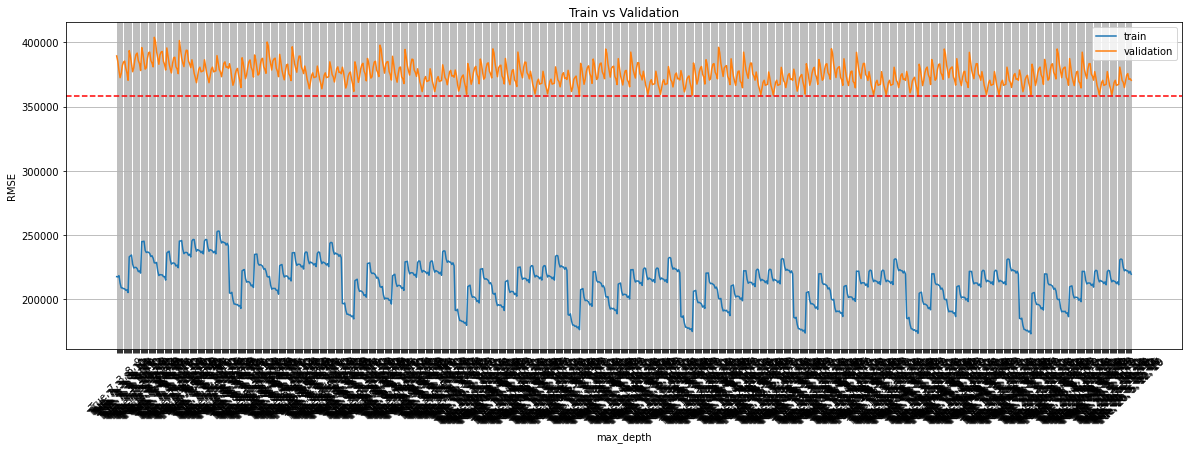

In [24]:
plt.figure(figsize=(20,6))

labels = []
for d in clf2.cv_results_["params"]:
    p = [str(v) for k,v in d.items()]
    labels.append(", ".join(p))

plot_train_validation_error(-clf2.cv_results_["mean_train_score"],
                            -clf2.cv_results_["mean_test_score"],
                            xlabel="max_depth",
                            xlabels= labels,
                            rotation=45
                           )

In [25]:
params = {
    'bootstrap': [True],
    'max_depth': list(range(9,15)),
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [4, 5, 6, 7],
    'n_estimators': list(range(15,25))
}
clf3 = best_model(RandomForestRegressor(random_state=24), params,
                 Xtrain=transform.transform(Xtrain),
                 ytrain=ytrain)



Best parameters:
Métrica neg_mean_squared_error: -364235.70
Parámetros: {'bootstrap': True, 'max_depth': 14, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 22}


In [26]:
rmse_rf_train3 = mean_squared_error(ytrain, clf3.predict(transform.transform(Xtrain)))
rmse_rf_test3 = mean_squared_error(ytest, clf3.predict(transform.transform(Xtest)))
r_2_rf_test3 = r2_score(ytest, clf3.predict(transform.transform(Xtest)))
print("RMSE train:", round(rmse_rf_train3,2))
print("RMSE test :", round(rmse_rf_test3,2))
print("R²        :", round(r_2_rf_test3,2))

RMSE train: 209487.7
RMSE test : 577720.35
R²        : 0.71


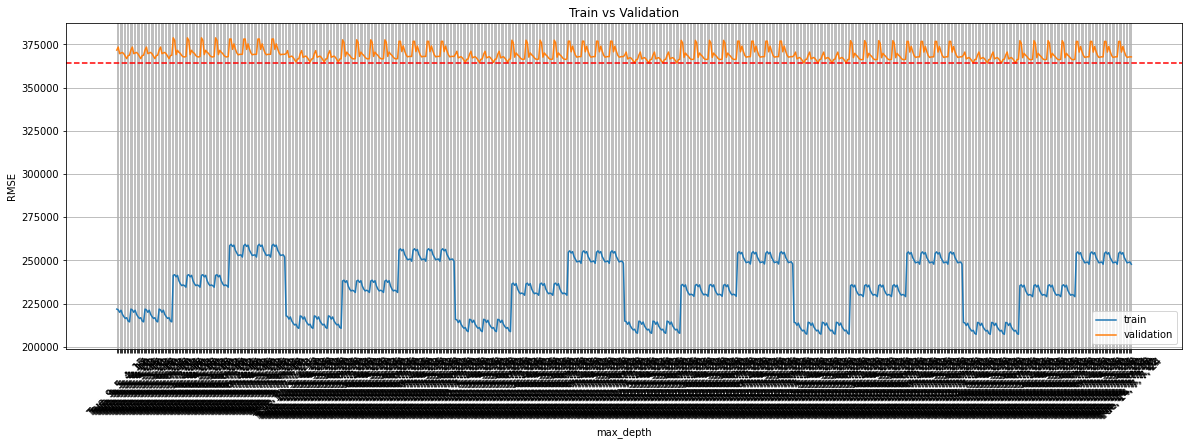

In [27]:
plt.figure(figsize=(20,6))

labels = []
for d in clf3.cv_results_["params"]:
    p = [str(v) for k,v in d.items()]
    labels.append(", ".join(p))

plot_train_validation_error(-clf3.cv_results_["mean_train_score"],
                            -clf3.cv_results_["mean_test_score"],
                            xlabel="max_depth",
                            xlabels= labels,
                            rotation=45
                           )

In [28]:
params = {
    'n_estimators': list(range(9,13)),
    'max_depth': list(range(4,15))
}
clf4 = best_model(RandomForestRegressor(random_state=24), params,
                 Xtrain=transform.transform(Xtrain),
                 ytrain=ytrain)



Best parameters:
Métrica neg_mean_squared_error: -353107.87
Parámetros: {'max_depth': 12, 'n_estimators': 12}


In [29]:
rmse_rf_train4 = mean_squared_error(ytrain, clf4.predict(transform.transform(Xtrain)))
rmse_rf_test4 = mean_squared_error(ytest, clf4.predict(transform.transform(Xtest)))
r_2_rf_test4 = r2_score(ytest, clf4.predict(transform.transform(Xtest)))
print("RMSE train:", round(rmse_rf_train4,2))
print("RMSE test :", round(rmse_rf_test4,2))
print("R²        :", round(r_2_rf_test4,2))

RMSE train: 80362.19
RMSE test : 548952.21
R²        : 0.72


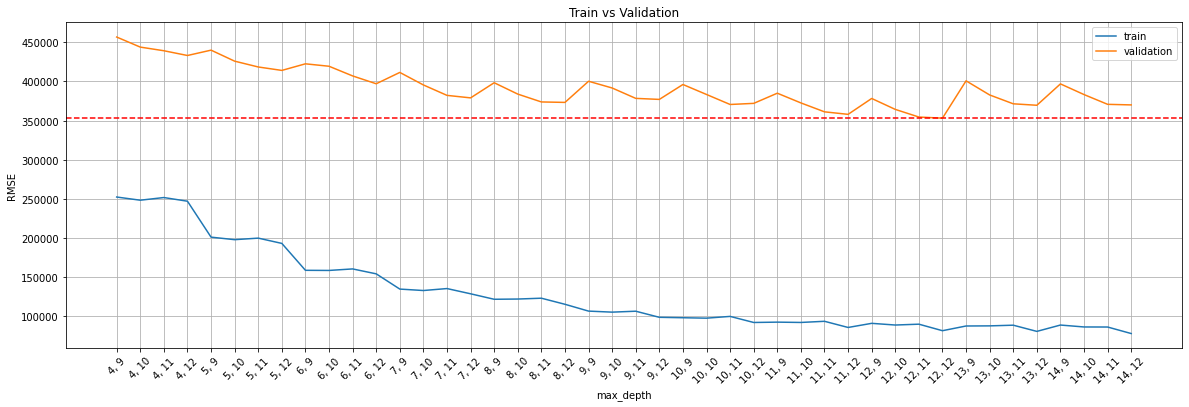

In [30]:
plt.figure(figsize=(20,6))

labels = []
for d in clf4.cv_results_["params"]:
    p = [str(v) for k,v in d.items()]
    labels.append(", ".join(p))

plot_train_validation_error(-clf4.cv_results_["mean_train_score"],
                            -clf4.cv_results_["mean_test_score"],
                            xlabel="max_depth",
                            xlabels= labels,
                            rotation=45
                           )

In [56]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
regr = MLPRegressor(hidden_layer_sizes=(100), random_state=1, max_iter=20000,).fit(transform.transform(Xtrain), ytrain)
print("Best loss", regr.best_loss_)
regr.predict(transform.transform(Xtest))

regr.score(transform.transform(Xtest), ytest)

Best loss 16435.054154806523


/home/jose/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6970208722491169

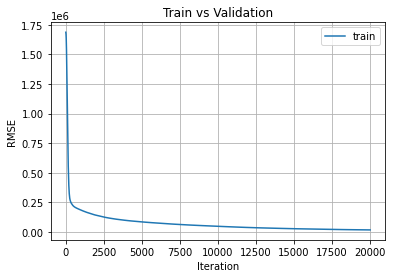

In [57]:
plot_train_validation_error(regr.loss_curve_,
                            None,
                            xlabel="Iteration",
                            xlabels= range(1,len(regr.loss_curve_)+1),
                            #rotation=45
                           )

In [77]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
regr = MLPRegressor(hidden_layer_sizes=(100), 
                    random_state=1,
                    max_iter=50000,).fit(transform.transform(Xtrain), ytrain)
regr.predict(transform.transform(Xtest))

regr.score(transform.transform(Xtest), ytest)

0.6962308161380129

Best loss 15854.73767804938


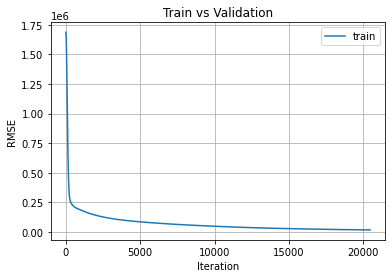

In [79]:
print("Best loss", regr.best_loss_)
plot_train_validation_error(regr.loss_curve_,
                            None,
                            xlabel="Iteration",
                            xlabels= range(1,len(regr.loss_curve_)+1),
                            #rotation=45
                           )

In [83]:
alquiler = pd.read_parquet("../data/madrid-rent-prices_4_cleaned.parquet")

madrid = gpd.read_file("../data/MADRID.geojson")
madrid = madrid[madrid.COD_POSTAL.str.startswith("280")]
madrid.shape

# Antes de transformar a lat, lon hay que proyectar el polígono
center_zipCode = madrid['geometry'].to_crs(epsg=3857).centroid
madrid['lon'] = center_zipCode.x
madrid['lat'] = center_zipCode.y

#Se han detectado códigos postales 28000 que no existen se transforman a 28001
print(alquiler.loc[alquiler.zipCode=="28000","zipCode"].shape)
alquiler.loc[alquiler.zipCode=="28000","zipCode"] = "28001"
print(alquiler.loc[alquiler.zipCode=="28000","zipCode"].shape)

madrid = madrid.set_index('COD_POSTAL')

# Incorporamos en alquiler lat, lon y eliminamos zipCode
alquiler = alquiler.join(madrid[['lon', 'lat']], on="zipCode")


(3,)
(0,)


In [94]:
to_plot = alquiler.groupby(['zipCode', 'lon', 'lat']).size().to_frame('count').reset_index()

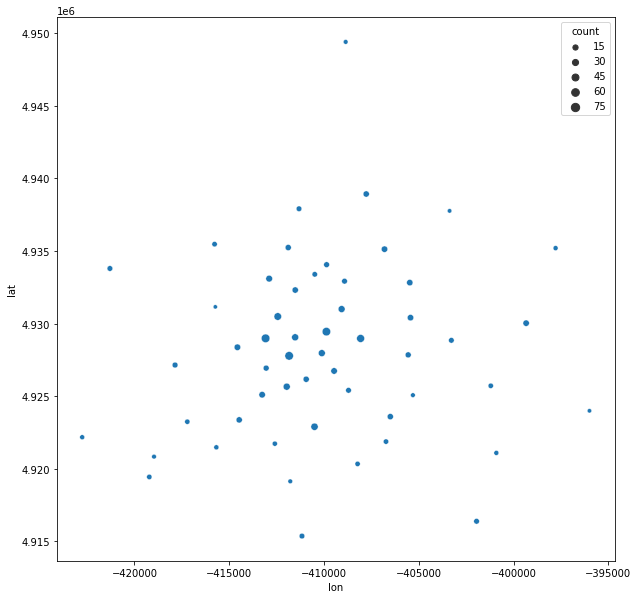

In [103]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=to_plot, x="lon", y="lat", size=to_plot['count'])
plt.show()